# Working With Harmonised METEOSAT Data

To ease access to METEOSAT data, I have created a harmonised dataset stored in the [zarr](https://zarr.readthedocs.io/en/stable/getting_started.html) format. The data is stored at `/heat_center/data/remote-sensing/meteosat/meteosat_LST_physical.zarr`/ It _should_ be possible to operate on this data using CDO, [R](https://www.r-bloggers.com/2022/09/reading-zarr-files-with-r-package-stars/) and of course through xarray.

A seperate intake catalog for remote sensing data is available:

In [1]:
import intake
from pathlib import Path

Open the Remote Sensing Catalog

In [2]:
catalog = intake.open_catalog(Path(Path.home(),'heat_center/data/remote-sensing/intake/remote-sensing.yaml'))

METEOSAT and MODIS data is available:

In [3]:
list(catalog)

['modis', 'meteosat']

METEOSAT Land Surface data is available in two variants, a product produced using a physically derived formula and a statistically derived version. For now only the full physically darived LST data set is available on the hub, as this is a more similar product to MODIS LST. I will download a small subset of Statisically derived LST for comparison. 

In [4]:
list(catalog['meteosat'])

['physical']

In [5]:
catalog['meteosat']['physical']

physical:
  args:
    urlpath: /home/pmarsh/heat_center/data/remote-sensing/intake/meteosat//../../meteosat/meteosat_LST_physical.zarr
  description: Meteosat LST Full Disc
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /home/pmarsh/heat_center/data/remote-sensing/intake/meteosat/
    tags:
    - remote-sensing
    - meteosat
    - LST
    - physical


In [6]:
%%time
ds = catalog['meteosat']['physical'].to_dask()
ds

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed
/share/apps/anaconda3-2022.05/envs/pangeo/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 3.13 s, sys: 2.2 s, total: 5.33 s
Wall time: 1min 34s


<xarray.Dataset> Size: 12TB
Dimensions:       (time: 219144, lat: 2600, lon: 2600)
Coordinates:
  * lat           (lat) float64 21kB -64.97 -64.92 -64.88 ... 64.88 64.93 64.98
  * lon           (lon) float64 21kB -64.97 -64.92 -64.88 ... 64.88 64.93 64.98
  * time          (time) datetime64[ns] 2MB 1991-01-01 ... 2015-12-31T23:00:00
Data variables:
    LSTERROR_PMW  (time, lat, lon) float32 6TB dask.array<chunksize=(500, 200, 200), meta=np.ndarray>
    LST_PMW       (time, lat, lon) float32 6TB dask.array<chunksize=(500, 200, 200), meta=np.ndarray>
    SATID         (time) float64 2MB dask.array<chunksize=(500,), meta=np.ndarray>

In [7]:
(ds.lat[0] - ds.lat[1])*111.1

<xarray.DataArray 'lat' ()> Size: 8B
array(-5.555)

In [8]:
ds.nbytes/1e9

11851.311067904

In [9]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

### Brief description of coordinates and variables:

Coordinates:
- lat/lon: This dataset is natively distributed in a WGS84 projection.
- time: This is a geostationary satellite and so time captured can be safely assumed to be consistent across the full grid. 

Variables:

- LST_PMW: Land Surface Temperature (at ~5.5km resolution). The PMW suffix identifies this as the physically derived product (Kelvin).
- LSTERROR_PMW: Land Surface Temperature Uncertainty (Kelvin).
- SATID: Spacecraft ID. The space craft used to capture this data has changed through the years. The Table below relates the SATID code to the satellite name. MSG = METEOSAT Second Generation and MFG = METEOSAT First Generation

| SATID | Name |
| --- | ----------- |
| 19 | MFG 4 |
| 20 | MFG 5 |
| 21 | MFG 6 |
| 22 | MFG 7 |
| 321 | MSG 1 | 
| 322 | MSG 2 |
| 323 | MSG 3 |



### Changing satellites through the years:

In [10]:
ds.SATID[::4000].values

array([ 19.,  19.,  19.,  19.,  19.,  19.,  19.,  20.,  20.,  20.,  20.,
        20.,  20.,  20.,  21.,  21.,  21.,  22.,  22.,  22.,  22.,  22.,
        22.,  22.,  22.,  22.,  22.,  22.,  22.,  22.,  22., 321., 321.,
       321., 321., 322., 322., 322., 322., 322., 322., 322., 322., 322.,
       322., 322., 322., 322., 322., 323., 323., 323., 323., 323., 323.])

### Spatial Plotting:

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

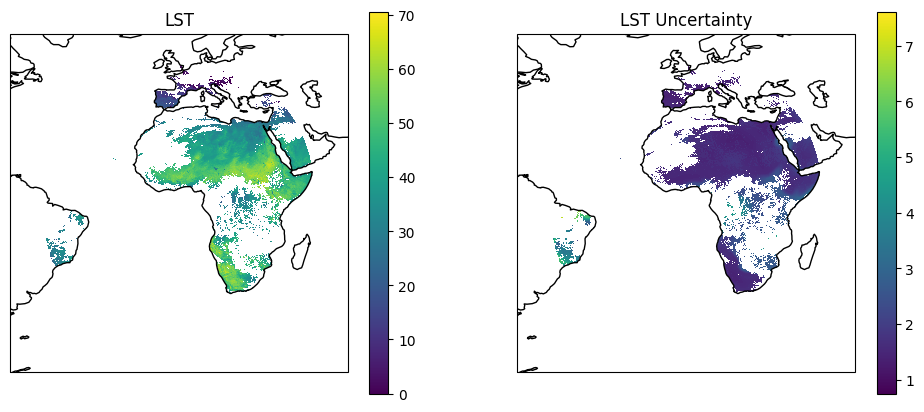

In [12]:
ds_sel = ds.sel(time = '2010-02-01 12:00:00')

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})

temp = (ds_sel.LST_PMW - 273.15).plot(x='lon', y='lat', transform=ccrs.PlateCarree(), vmin =0, cmap = 'viridis', ax = axes[0], add_colorbar=False)
axes[0].coastlines()
fig.colorbar(temp, ax=axes[0], shrink = 0.55)
axes[0].set_title('LST')

error = ds_sel.LSTERROR_PMW.plot(x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = 'viridis', ax = axes[1], add_colorbar=False)
axes[1].coastlines()
fig.colorbar(error, ax=axes[1], shrink = 0.55)
axes[1].set_title('LST Uncertainty')

plt.savefig('/home/pmarsh/newfig.png')

### Time Series Plotting

Johannesburg:

In [17]:
%%time

lat_, lon_ = -26.198513, 28.029066 #JHB

ds_sel = ds.sel(lat = lat_, lon = lon_, method = 'nearest') - 273.15

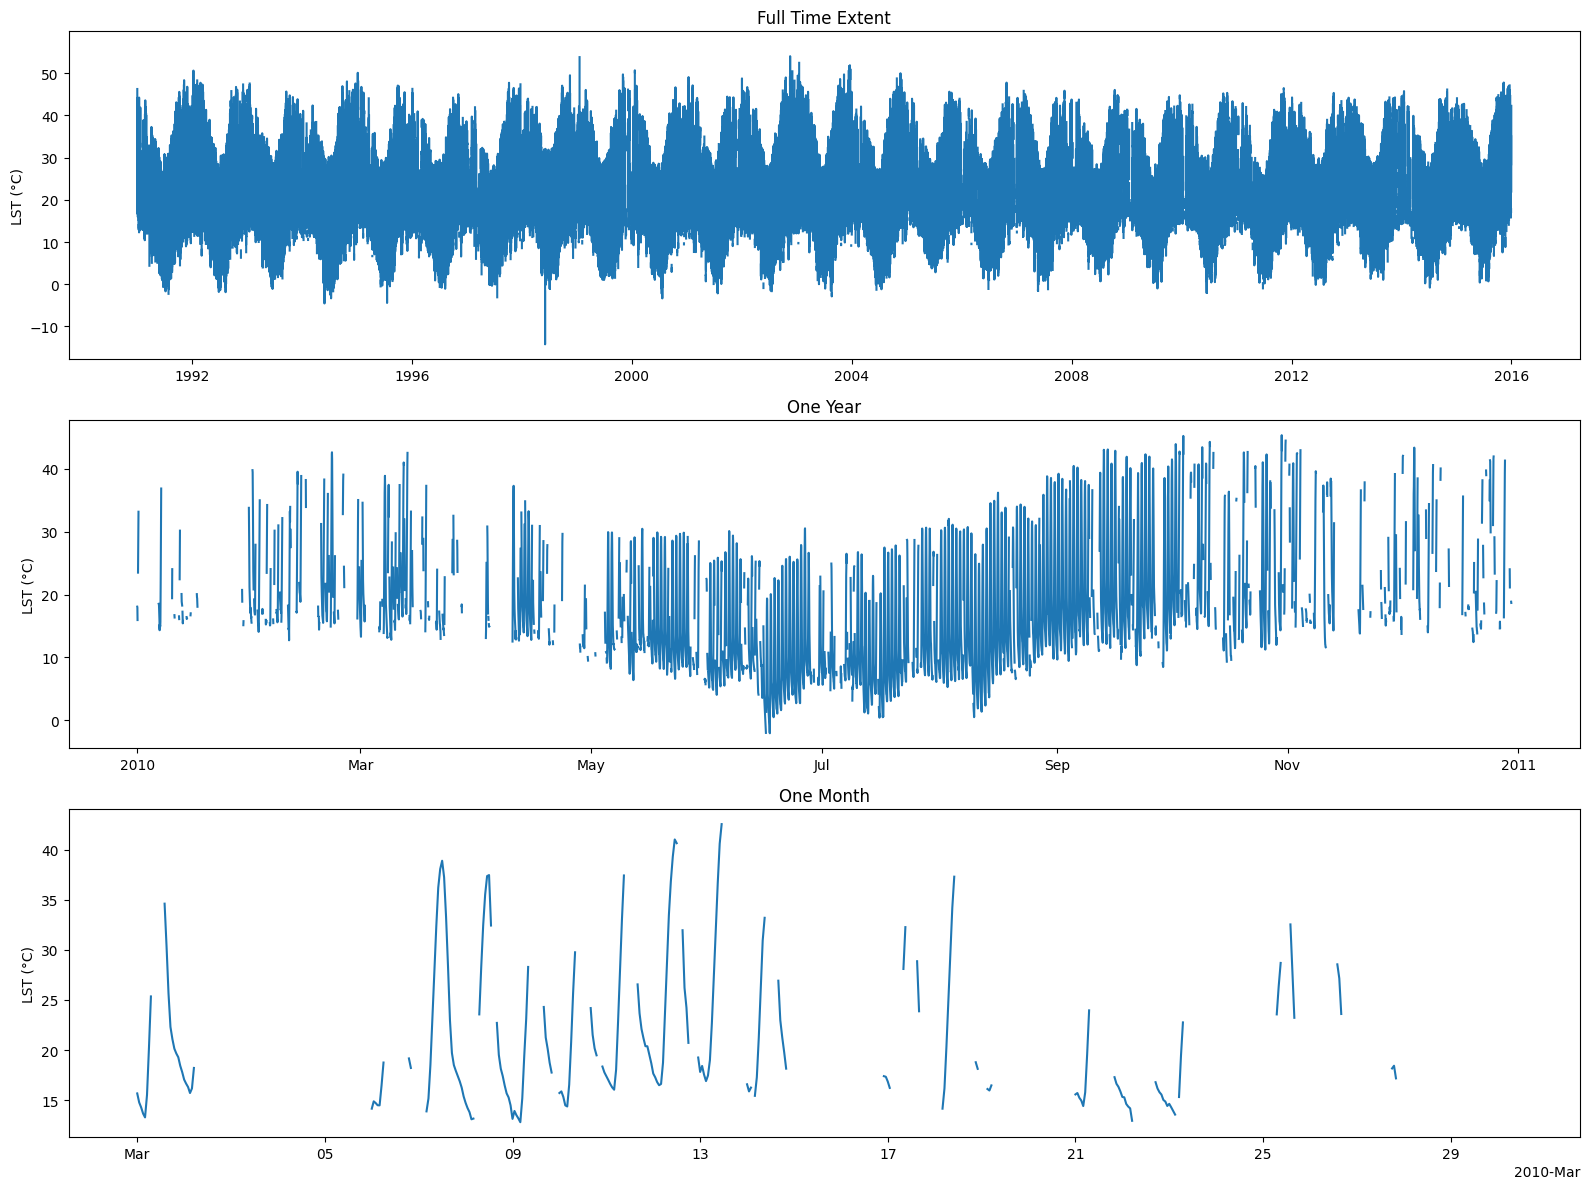

In [21]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(16,12))

ds_sel.LST_PMW.plot(ax = axes[0])
axes[0].set_title('Full Time Extent')
axes[0].set_xlabel('')
axes[0].set_ylabel('LST (°C)')

ds_sel.sel(time = '2010').LST_PMW.plot(ax = axes[1])
axes[1].set_title('One Year')
axes[1].set_xlabel('')
axes[1].set_ylabel('LST (°C)')

ds_sel.sel(time = '2010-03').LST_PMW.plot(ax = axes[2])
axes[2].set_title('One Month')
axes[2].set_xlabel('')
axes[2].set_ylabel('LST (°C)')

plt.tight_layout()

plt.savefig('time_gappy_time_series.png')

Abidjan:

CPU times: user 1min 27s, sys: 14.2 s, total: 1min 42s
Wall time: 6.92 s


Text(0.5, 0, '')

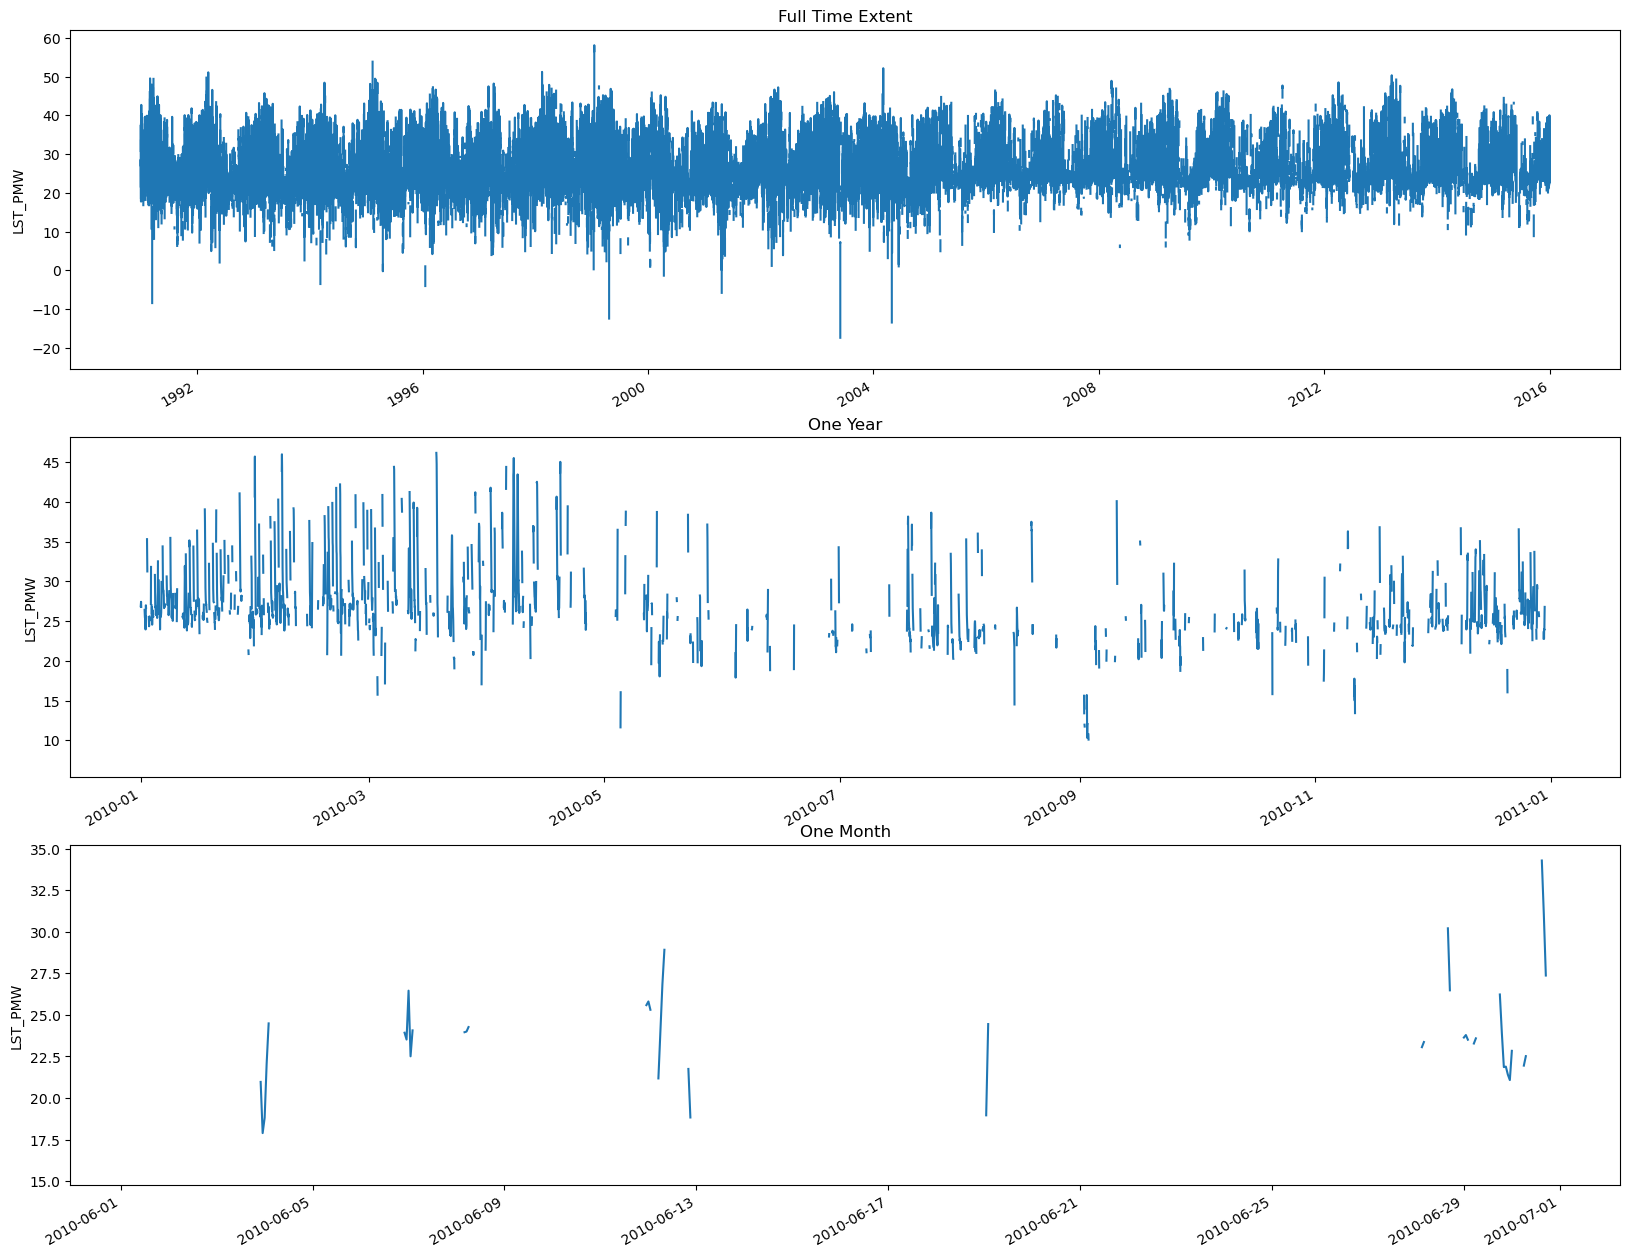

In [12]:
%%time

lat_, lon_ = 5.383200, -4.038460 #ABJ

ds_sel = ds.sel(lat = lat_, lon = lon_, method = 'nearest') - 273.15

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(20,15))

ds_sel.LST_PMW.plot(ax = axes[0])
axes[0].set_title('Full Time Extent')
axes[0].set_xlabel('')

ds_sel.sel(time = '2010').LST_PMW.plot(ax = axes[1])
axes[1].set_title('One Year')
axes[1].set_xlabel('')

ds_sel.sel(time = '2010-06').LST_PMW.plot(ax = axes[2])
axes[2].set_title('One Month')
axes[2].set_xlabel('')

Significantly more missing data in Abidjan, presumably due to increased cloud cover.